<a href="https://colab.research.google.com/github/davidkubanek/Thesis/blob/main/concerto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create Dataset
- add fingerprints
- add graph embeddings

In [2]:
# for running in colab
!pip install dgl
!pip install rdkit
!pip install torch_geometric
!pip install wandb
!pip install pydantic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 9.0 MB/s eta 0:00:0000:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 28.3 MB/s eta 0:00:00a 0:00:01


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
if not torch.cuda.is_available():
  plt.rcParams["font.family"] = "Palatino"

# import dgl
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch_geometric.loader import DataLoader
import wandb
import warnings
from tqdm import tqdm

from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

# check if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Data

### NP Atlas

In [18]:
# import smiles from csv
import pandas as pd

npatlas_fungal_smiles = pd.read_csv('../Data/Molecules/NPAtlas/fungal_smiles.csv')
# convert to list

npatlas_fungal_smiles = npatlas_fungal_smiles['smiles'].tolist()

# Representation

## Fingerprints
smiles →  fingerprints

In [6]:
def convert_smile_to_fp_bit_string(smile):
        """
        Convert SMILES string to concatenation of RDFKIT, Morgan and MACCSS fingerprints.
        """
        # RDFKIT (fingerprint dim fpSize=1024)
        x = Chem.MolFromSmiles(smile)
        fp1 = Chem.RDKFingerprint(x, fpSize=1024)

        # MACCSS substructure (fingerprint dim 167)
        fp2 = MACCSkeys.GenMACCSKeys(x)

        # Morgan (fingerprint dim fpSize=1024)
        fp_hashes = []
        fp3 = AllChem.GetHashedMorganFingerprint(x, 2, nBits=1024)
        fp3_array = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp3, fp3_array)
        fp_hashes.append(fp3_array)

        # combine all fingerprints
        fp = fp1.ToBitString() + fp2.ToBitString()
        fp = np.array(list(fp)).astype(np.int8)
        fp = np.concatenate([fp] + fp_hashes)
        fp = torch.tensor(fp).to(torch.float32)
        return fp

Get sample fingerprint

SMILES: CC[C@H](C)[C@@H](CO)NC(=O)/C=C/[C@](C)([C@H]([C@@H](C)C[C@@H](CC)O)O)OC
Fingerprint: tensor([1., 0., 1.,  ..., 0., 0., 0.]) torch.Size([2215])


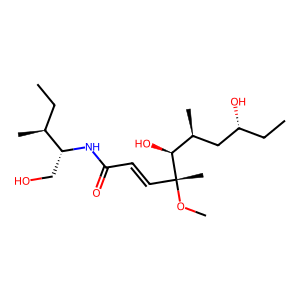

In [20]:
smile = npatlas_fungal_smiles[0]
fp = convert_smile_to_fp_bit_string(smile)
print('SMILES:', smile)
print('Fingerprint:', fp, fp.shape)

x = Chem.MolFromSmiles(smile)
from rdkit.Chem import Draw
img = Draw.MolToImage(x)
img

## Graph embedding
smiles →  graph embedding

In [32]:
# smiles to graphs
import numpy as np

# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

# Pytorch and Pytorch Geometric
import torch
from torch_geometric.data import Data
from torch.utils.data import DataLoader

class GraphDatasetClass:
    '''
    Convert a dataframe of SMILES into a Pytorch Geometric Graph Dataset.
    https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/
    '''

    def __init__(self):
        pass

    def one_hot_encoding(self, x, permitted_list):
        """
        Maps input elements x which are not in the permitted list to the last element
        of the permitted list.
        """

        if x not in permitted_list:
            x = permitted_list[-1]

        binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]

        return binary_encoding


    def get_atom_features(self, atom,
                        use_chirality = True,
                        hydrogens_implicit = True):
        """
        Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
        """

        # define list of permitted atoms

        permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']

        if hydrogens_implicit == False:
            permitted_list_of_atoms = ['H'] + permitted_list_of_atoms

        # compute atom features

        atom_type_enc = self.one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)

        n_heavy_neighbors_enc = self.one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])

        formal_charge_enc = self.one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])

        hybridisation_type_enc = self.one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])

        is_in_a_ring_enc = [int(atom.IsInRing())]

        is_aromatic_enc = [int(atom.GetIsAromatic())]

        atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]

        vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]

        covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

        atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled

        if use_chirality == True:
            chirality_type_enc = self.one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
            atom_feature_vector += chirality_type_enc

        if hydrogens_implicit == True:
            n_hydrogens_enc = self.one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
            atom_feature_vector += n_hydrogens_enc

        return np.array(atom_feature_vector)

    def get_bond_features(self, bond,
                        use_stereochemistry = True):
        """
        Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
        """

        permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

        bond_type_enc = self.one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)

        bond_is_conj_enc = [int(bond.GetIsConjugated())]

        bond_is_in_ring_enc = [int(bond.IsInRing())]

        bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc

        if use_stereochemistry == True:
            stereo_type_enc = self.one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
            bond_feature_vector += stereo_type_enc

        return np.array(bond_feature_vector)

    def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(self, x_smiles):
        """
        Inputs:

        x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
        y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)

        Outputs:

        data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning

        """

        data_list = []

        for smiles in tqdm(x_smiles, desc='Creating graph dataset...', total=len(x_smiles)):

            # convert SMILES to RDKit mol object
            mol = Chem.MolFromSmiles(smiles)

            # get feature dimensions
            n_nodes = mol.GetNumAtoms()
            n_edges = 2*mol.GetNumBonds()
            unrelated_smiles = "O=O"
            unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
            n_node_features = len(self.get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
            n_edge_features = len(self.get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

            # construct node feature matrix X of shape (n_nodes, n_node_features)
            X = np.zeros((n_nodes, n_node_features))

            for atom in mol.GetAtoms():
                X[atom.GetIdx(), :] = self.get_atom_features(atom)

            X = torch.tensor(X, dtype = torch.float)

            # construct edge index array E of shape (2, n_edges)
            (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
            torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
            torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
            E = torch.stack([torch_rows, torch_cols], dim = 0)

            # construct edge feature array EF of shape (n_edges, n_edge_features)
            EF = np.zeros((n_edges, n_edge_features))

            for (k, (i,j)) in enumerate(zip(rows, cols)):

                EF[k] = self.get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))

            EF = torch.tensor(EF, dtype = torch.float)


            # construct Pytorch Geometric data object and append to data list
            data_list.append(Data(x = X, edge_index = E, edge_attr = EF))

        return data_list

## GROVER: graph transformer  fingerprints
smiles → node/edge features using RDkit → to fingerprint embedding using GTransformer

In [22]:
# import fingerprint .np file
directory = '../Data/Molecules/NPAtlas/'
grover_fp = np.load(directory + 'fp_grover_large_fungal.npz', allow_pickle=True)
print(grover_fp.keys())  # Display the keys or attributes in the file

Index(['smiles', 'fps'], dtype='object')


In [23]:
grover_fp

,smiles,fps
0,CC[C@H](C)[C@@H](CO)NC(=O)/C=C/[C@](C)([C@H]([...,"[-0.092143126, -0.2031826, 0.45538482, -0.4365..."
1,C[C@H]1[C@@H](CCC2=CC(=O)[C@@H](C[C@]12C)C(=C)...,"[0.02064852, -0.26870528, 0.2097366, -0.430466..."
2,C[C@]1(CCC[C@]2([C@H]1CC=C3[C@@H]2C[C@]45C(O4)...,"[-0.043161456, 0.13534242, 0.6861116, -0.37898..."
3,C[C@]12C[C@@H](C[C@H](O1)C3=C(O2)C=C4C(=C3O)C(...,"[-0.20194033, 0.008340213, 0.27664647, 0.18652..."
4,COC1=CC(=CC(=O)C(=C1O)OC)C(=O)O,"[-0.22794804, -0.081468806, 0.43191895, -0.051..."
...,...,...
20299,C.CC1=C[C@@H]2C[C@H](C)CCC2[C@]2(C)C(=O)O[C@H]...,"[0.24402617, -0.1884088, -0.16766152, -0.51528..."
20300,CC(/C=C/CC(C)CC/C=C(\C)C(O)=C1C(=O)[C@H](C)N(C...,"[0.05457084, -0.23697326, 0.2597923, -0.552401..."
20301,CC(/C=C/CC(C)/C=C/C=C(\C)C(O)=C1C(=O)[C@H](C)N...,"[0.07585665, -0.3176158, 0.29438573, -0.557274..."
20302,CC(=O)O[C@@H]1CC(=O)OC(C)(C)[C@H]2CC[C@@]3(C)[...,"[0.034069292, -0.19464077, 0.3619269, -0.54580..."


# Dataset

In [27]:
args = {}
args['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data parameters
args['num_data_points'] = 20304 #320016 # number of data points to use


args['assay_start'] = 0 # which assay to start from

args['num_node_features'] = 79 # number of node features in graph representation
args['grover_fp_dim'] = 5000 #grover_fp['fps'][0].shape[0] # None  # dim of grover fingerprints
args['fp_dim'] = 2215 # dim of fingerprints


In [41]:
from torch_geometric.loader import DataLoader

def prepare_datalist(smiles, args, graph_fp=True, grover_fp=None):
    '''
    Convert matrix dataframe to a data_list with pytorch geometric graph data, fingerprints and labels.
    Inputs:
        matrix_df: dataframe of SMILES, assays and bioactivity labels
        args: arguments
        graph_fp: if True, includes graph embedding fingerprints into data_list
        grover_fp: if True, includes GROVER graph transformer embedding fingerprints into data_list
    Outputs:
        data_list: list of data objects
    '''

    # get SMILES strings
    data = smiles


    # add graph fingerprint
    if graph_fp is True: 
        GraphDataset = GraphDatasetClass()
        # create pytorch geometric graph data list
        data_list = GraphDataset.create_pytorch_geometric_graph_data_list_from_smiles_and_labels(data)
   
    else: # create simple data_list without graph fingerprint
      data_list = []
    #   for label in y:
    #       # construct Pytorch Geometric data object and append to data list
    #       data_list.append(Data(y = label.reshape(1, -1)))
    
    
    # add fingerprint data to each graph
    for i, smile in tqdm(enumerate(data), desc='Adding fingerprints...', total=len(data)):
        fp = convert_smile_to_fp_bit_string(smile)
        data_list[i].fp = fp 


    # add grover fingerprint to each graph
    if grover_fp is not None:
        for i, gfp in tqdm(enumerate(grover_fp['fps'][:args['num_data_points']]), desc='Adding grover embedding...', total=len(data)):
          data_list[i].grover_fp = torch.tensor(gfp)


    print(f'Example of a graph data object: {data_list[0]}')

    return data_list

def prepare_dataloader(data_list, args):
    '''
    Get dataloader dictionary from data_list with desired batch_size
    '''
    data_list = data_list[:args['num_data_points']]
    # split into train and test
    train_dataset = data_list[:int(len(data_list)*0.8)]
    test_dataset = data_list[int(len(data_list)*0.8):]

    # split into train and validation
    val_dataset = train_dataset[:int(len(train_dataset)*0.25)]
    train_dataset = train_dataset[int(len(train_dataset)*0.25):]

    print(f'Number of training graphs: {len(train_dataset)}')
    print(f'Number of validation graphs: {len(val_dataset)}')
    print(f'Number of test graphs: {len(test_dataset)}')
    print(f'Example of a graph data object: {data_list[0]}')

    # create data loaders
    dataloader = {}
    dataloader['train'] = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True)
    dataloader['val'] = DataLoader(val_dataset, batch_size=args['batch_size'], shuffle=False)
    dataloader['test'] = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=False)

    return dataloader

def analyze_dataset(dataset, args):
    '''
    Analyze the distribution of positive classes in the dataset
    '''
    positive = []
    for i in range(len(dataset)):
        positive.append(dataset[i].y[0].sum().item())


    num_assays = args['num_assays']
    # make histogram of the number of positive
    plt.figure(figsize=(7, 4))
    # define bins
    bins = np.linspace(0, num_assays, num_assays+1)-0.5
    plt.hist(positive, bins=bins, alpha=0.5, label='train')
    num_assays = args['num_assays']
    plt.xlabel(f'# of positive hits in target vector (out of {num_assays})')
    plt.ylabel('Number of data points')
    plt.title('Histogram of positive class distribution')
    plt.show()

    # for i in range(num_assays+1):
    #     print(f'Number of data points with {i} positive targets: ', (np.array(positive) == i).sum(), f'({(np.array(positive) == i).sum()/len(positive)*100:.2f}%)')

def data_explore(dataloader):
    '''
    Explore the data
    '''
    # check proportion of positive and negative samples across each assay
    pos = torch.zeros(args['num_assays'])
    for data in dataloader:  # Iterate in batches over the training dataset
        # print('inputs:')
        # print(' x:', data.x.shape, '| y:',data.y.shape, '| fp:',data.fp.shape, '| grover:', data.grover_fp.shape)
        pos += data.y.sum(axis=0)
        #  print(data.y.sum(axis=0))
    print('# positive samples:', pos)
    print(torch.round((pos/len(dataloader.dataset)*100),decimals=2),'% are positive')



In [42]:
data_list = prepare_datalist(grover_fp['smiles'], args, graph_fp=True, grover_fp=grover_fp)

Adding grover embedding...: 100%|██████████| 20304/20304 [00:00<00:00, 49802.57it/s]


Example of a graph data object: Data(x=[25, 79], edge_index=[2, 48], edge_attr=[48, 10], fp=[2215], grover_fp=[5000])


In [43]:
data_list[0]

Data(x=[25, 79], edge_index=[2, 48], edge_attr=[48, 10], fp=[2215], grover_fp=[5000])

In [40]:
data_list[0].edge_attr

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 1.],


In [31]:
data_list

[Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[5000]),
 Data(fp=[2215], grover_fp=[

Save data_list

In [45]:
import pickle

directory = '../Data/biohack/'
save_path = directory + 'datalist_fungal_test.pkl'

# Save the dictionary using pickle
with open(save_path, 'wb') as f:
    pickle.dump(data_list, f)


# Load data

In [ ]:
# training parameters
args['model'] = 'GROVER_FP' # 'GCN', 'GCN_FP', 'FP', 'GROVER', 'GROVER_FP'
args['num_layers'] = 3 # number of layers in MLP
args['hidden_channels'] = 256 # 64
args['dropout'] = 0.2
args['batch_size'] = 256
args['num_epochs'] = 100
args['lr'] = 0.01
#args['gradient_clip_norm'] = 1.0
#args['network_weight_decay'] = 0.0001
args['lr_decay_factor'] = 0.5

# check batch size -> to include examples of classes
# dropout maybe higher

In [ ]:
import pickle

if torch.cuda.is_available():
    directory = '/content/drive/MyDrive/Thesis/Data/'
else:
    directory = '/Volumes/Kubánek UCL/Data/Thesis MSc/PubChem Data/final/'
# Specify the path where you saved the dictionary
load_path = directory + 'datalist_no_out.pkl'

# Load the dictionary using pickle
with open(load_path, 'rb') as f:
    data_list = pickle.load(f)
